In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import math

from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import lightgbm as lgb

from random import choices
from datetime import datetime,timedelta
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score,fbeta_score

### Reading the data file 

In [2]:
bb= pd.read_csv('pre_feat.csv')
bb.head()

,date,serial_number,model,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_241_raw,smart_242_raw
0,2019-01-01,Z305B2QN,ST4000DM000,4000787030016,0,0.0,26712.0,0.0,0.0,34169.0,20.0,0.0,0.0,4.553972e+10,1.183566e+11
1,2019-01-01,ZJV0XJQ4,ST12000NM0007,12000138625024,0,0.0,3753.0,0.0,0.0,2145.0,28.0,0.0,0.0,2.887057e+10,2.160959e+10
2,2019-01-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,0.0,792.0,0.0,0.0,363.0,34.0,0.0,0.0,6.111459e+09,7.441231e+08
3,2019-01-01,ZJV0XJQ0,ST12000NM0007,12000138625024,0,0.0,4356.0,0.0,0.0,687.0,22.0,0.0,0.0,3.350759e+10,3.938334e+10
4,2019-01-01,ZA16NQJR,ST8000NM0055,8001563222016,0,0.0,14673.0,0.0,0.0,15470.0,35.0,0.0,0.0,4.771906e+10,9.485711e+10


### Changing Capacity from bytes to Terabytes

In [3]:
bb['capacity_tb']=bb['capacity_bytes']/1e12

In [4]:
bb=bb.drop(['capacity_bytes'],axis=1)

### Counts of failure(class-1) and non-failure(class-0) drives

In [5]:
bb['failure'].value_counts()

0    7394485
1        387
Name: failure, dtype: int64

### Changing date(feature) format from string to datetime

In [6]:
bb['date'] = pd.to_datetime(bb['date'], format='%Y-%m-%d')

### Creating dataframe of failure drive only

In [7]:
bb_fail= bb[bb['failure']==1]
bb_fail.shape

(387, 15)

In [8]:
bb_w= bb[bb['failure']==0]
bb_w.shape

(7394485, 15)

### Creating dataframe of drives that failed but present in dataset multiple times in running state

In [9]:
bb_wf = bb.loc[bb['serial_number'].isin(bb_fail['serial_number'])]
bb_wf= bb_wf[bb_wf['failure']==0]
bb_wf.shape

(16792, 15)

In [10]:
bb_wf.head()

,date,serial_number,model,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_241_raw,smart_242_raw,capacity_tb
114,2019-01-01,Z304JN7J,ST4000DM000,0,0.0,28392.0,0.0,0.0,7273.0,23.0,0.0,0.0,4.796113e+10,1.341161e+11,4.000787
194,2019-01-01,ZCH05KWT,ST12000NM0007,0,24.0,11650.0,12.0,0.0,633.0,40.0,88.0,88.0,6.049029e+10,1.213064e+11,12.000139
297,2019-01-01,ZA16DSXV,ST8000NM0055,0,0.0,15892.0,0.0,0.0,14936.0,29.0,0.0,0.0,5.012936e+10,1.102447e+11,8.001563
356,2019-01-01,ZCH080T0,ST12000NM0007,0,0.0,10487.0,0.0,0.0,1501.0,25.0,0.0,0.0,5.349964e+10,8.614009e+10,12.000139
727,2019-01-01,ZA1890DY,ST8000NM0055,0,3896.0,12937.0,1.0,0.0,14353.0,38.0,0.0,0.0,4.252652e+10,1.072186e+11,8.001563


### Changing drive status to fail(class- 0 to 1), by backtracking(smoothing). By going n days(=10days) back of the failure drives we are changing the drive status from runnig to failure(0 → 1).

In [268]:
from tqdm import tqdm
c=0
for ind in tqdm(bb_fail.index):
    for j in bb_wf.index:
        if (bb_fail['serial_number'][ind]== bb_wf['serial_number'][j]) and \
        ((bb_wf['date'][j]== (bb_fail['date'][ind]-timedelta(days=1))) or \
         (bb_wf['date'][j]== (bb_fail['date'][ind]-timedelta(days=2))) or \
         (bb_wf['date'][j]== (bb_fail['date'][ind]-timedelta(days=3))) or \
         (bb_wf['date'][j]== (bb_fail['date'][ind]-timedelta(days=4))) or \
         (bb_wf['date'][j]== (bb_fail['date'][ind]-timedelta(days=5))) or \
         (bb_wf['date'][j]== (bb_fail['date'][ind]-timedelta(days=6))) or \
         (bb_wf['date'][j]== (bb_fail['date'][ind]-timedelta(days=7))) or \
         (bb_wf['date'][j]== (bb_fail['date'][ind]-timedelta(days=8))) or \
         (bb_wf['date'][j]== (bb_fail['date'][ind]-timedelta(days=9))) or \
         (bb_wf['date'][j]== (bb_fail['date'][ind]-timedelta(days=10)))):
                 
            #print(bb_fail['serial_number'][ind])
            bb_wf.at[j,'failure']=1
            c+=1
print(c)

100%|████████████████████████████████████████████████████████████████████████████████| 387/387 [03:02<00:00,  2.12it/s]

3613


### Counting the failure drives after Smoothing

In [270]:
bb_wf['failure'].value_counts()

0    13179
1     3613
Name: failure, dtype: int64

### Putting the actual fail drive and the drives that converted from running to failure into a dataframe

In [271]:
bb_hf= bb_wf[bb_wf['failure']==1]

In [272]:
fail=[bb_fail,bb_hf]

bb_10= pd.concat(fail)
bb_10.shape

(4000, 15)

### Randomly picking running drives 

In [274]:
bb_nf= bb_wf[bb_wf['failure']==0]
bb_ran= bb_nf.sample(4000)

In [276]:
d=[bb_10,bb_ran]
data= pd.concat(d)
data.shape

(8000, 15)

In [ ]:
data.to_csv('10_days.csv')

## Loading the dataset 

In [5]:
df= pd.read_csv('15_days.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.shape

(11642, 15)

In [6]:
df['failure'].value_counts()

0    6000
1    5642
Name: failure, dtype: int64

In [7]:
df.head()

,date,serial_number,model,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_241_raw,smart_242_raw,capacity_tb
0,2019-01-01,ZA18197Z,ST8000NM0055,1,29616.0,12419.0,112.0,0.000000e+00,4899.0,41.0,0.0,0.0,3.950897e+10,8.143129e+10,8.001563
1,2019-01-01,S300YTAY,ST4000DM000,1,760.0,31801.0,0.0,0.000000e+00,36331.0,19.0,0.0,0.0,5.381062e+10,1.178197e+11,4.000787
2,2019-01-01,S300ZREZ,ST4000DM000,1,40.0,30678.0,51.0,0.000000e+00,35093.0,25.0,24.0,24.0,5.472184e+10,1.305077e+11,4.000787
3,2019-01-01,ZA180YM3,ST8000NM0055,1,0.0,12921.0,0.0,0.000000e+00,11607.0,43.0,0.0,0.0,4.250631e+10,9.330213e+10,8.001563
4,2019-01-02,ZDEB35E7,ST500LM030,1,0.0,3204.0,0.0,8.590066e+09,8.0,36.0,0.0,0.0,1.740791e+10,5.154608e+09,0.500108


### Encoding the categorical feature 'model'

In [8]:
from sklearn.preprocessing import LabelEncoder

encoder= LabelEncoder()
model = encoder.fit_transform(df['model'])

In [9]:
df['model']=model

### Removing date, serial number columns

In [10]:
y=df['failure']
X= df.drop(['date','serial_number','failure'],axis=1)

In [11]:
X.head()

,model,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_241_raw,smart_242_raw,capacity_tb
0,7,29616.0,12419.0,112.0,0.000000e+00,4899.0,41.0,0.0,0.0,3.950897e+10,8.143129e+10,8.001563
1,2,760.0,31801.0,0.0,0.000000e+00,36331.0,19.0,0.0,0.0,5.381062e+10,1.178197e+11,4.000787
2,2,40.0,30678.0,51.0,0.000000e+00,35093.0,25.0,24.0,24.0,5.472184e+10,1.305077e+11,4.000787
3,7,0.0,12921.0,0.0,0.000000e+00,11607.0,43.0,0.0,0.0,4.250631e+10,9.330213e+10,8.001563
4,3,0.0,3204.0,0.0,8.590066e+09,8.0,36.0,0.0,0.0,1.740791e+10,5.154608e+09,0.500108


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Normalizing the dataset

In [61]:
normm= Normalizer()
normm.fit(X_train['model'].values.reshape(-1,1))
X_tr_m= csr_matrix(normm.transform(X_train['model'].values.reshape(-1,1)))
X_te_m= csr_matrix(normm.transform(X_test['model'].values.reshape(-1,1)))

normcp= Normalizer()
normcp.fit(X_train['capacity_tb'].values.reshape(-1,1))
X_tr_cp= csr_matrix(normcp.transform(X_train['capacity_tb'].values.reshape(-1,1)))
X_te_cp= csr_matrix(normcp.transform(X_test['capacity_tb'].values.reshape(-1,1)))

norm5= Normalizer()
norm5.fit(X_train['smart_5_raw'].values.reshape(-1,1))
X_tr_5= csr_matrix(norm5.transform(X_train['smart_5_raw'].values.reshape(-1,1)))
X_te_5= csr_matrix(norm5.transform(X_test['smart_5_raw'].values.reshape(-1,1)))

norm9= Normalizer()
norm9.fit(X_train['smart_9_raw'].values.reshape(-1,1))
X_tr_9= csr_matrix(norm9.transform(X_train['smart_9_raw'].values.reshape(-1,1)))
X_te_9= csr_matrix(norm9.transform(X_test['smart_9_raw'].values.reshape(-1,1)))

norm187= Normalizer()
norm187.fit(X_train['smart_187_raw'].values.reshape(-1,1))
X_tr_187= csr_matrix(norm187.transform(X_train['smart_187_raw'].values.reshape(-1,1)))
X_te_187= csr_matrix(norm187.transform(X_test['smart_187_raw'].values.reshape(-1,1)))

norm188= Normalizer()
norm188.fit(X_train['smart_188_raw'].values.reshape(-1,1))
X_tr_188= csr_matrix(norm188.transform(X_train['smart_188_raw'].values.reshape(-1,1)))
X_te_188= csr_matrix(norm188.transform(X_test['smart_188_raw'].values.reshape(-1,1)))

norm193= Normalizer()
norm193.fit(X_train['smart_193_raw'].values.reshape(-1,1))
X_tr_193= csr_matrix(norm193.transform(X_train['smart_193_raw'].values.reshape(-1,1)))
X_te_193= csr_matrix(norm193.transform(X_test['smart_193_raw'].values.reshape(-1,1)))

norm194= Normalizer()
norm194.fit(X_train['smart_194_raw'].values.reshape(-1,1))
X_tr_194= csr_matrix(norm194.transform(X_train['smart_194_raw'].values.reshape(-1,1)))
X_te_194= csr_matrix(norm194.transform(X_test['smart_194_raw'].values.reshape(-1,1)))

norm197= Normalizer()
norm197.fit(X_train['smart_197_raw'].values.reshape(-1,1))
X_tr_197= csr_matrix(norm197.transform(X_train['smart_197_raw'].values.reshape(-1,1)))
X_te_197= csr_matrix(norm197.transform(X_test['smart_197_raw'].values.reshape(-1,1)))

norm198= Normalizer()
norm198.fit(X_train['smart_198_raw'].values.reshape(-1,1))
X_tr_198= csr_matrix(norm197.transform(X_train['smart_198_raw'].values.reshape(-1,1)))
X_te_198= csr_matrix(norm197.transform(X_test['smart_198_raw'].values.reshape(-1,1)))

norm241= Normalizer()
norm241.fit(X_train['smart_241_raw'].values.reshape(-1,1))
X_tr_241= csr_matrix(norm241.transform(X_train['smart_241_raw'].values.reshape(-1,1)))
X_te_241= csr_matrix(norm241.transform(X_test['smart_241_raw'].values.reshape(-1,1)))

norm242= Normalizer()
norm242.fit(X_train['smart_242_raw'].values.reshape(-1,1))
X_tr_242= csr_matrix(norm187.transform(X_train['smart_242_raw'].values.reshape(-1,1)))
X_te_242= csr_matrix(norm187.transform(X_test['smart_242_raw'].values.reshape(-1,1)))

In [62]:
X_tr_enc= hstack((X_tr_m,X_tr_cp,X_tr_5,X_tr_9,X_tr_187,X_tr_188,X_tr_193,X_tr_194,X_tr_197,X_tr_198,X_tr_241,X_tr_242)).tocsr()
X_te_enc= hstack((X_te_m,X_te_cp,X_te_5,X_te_9,X_te_187,X_te_188,X_te_193,X_te_194,X_te_197,X_te_198,X_te_241,X_te_242)).tocsr()

## K-NN Classifier

In [73]:
k_range = list([3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45])
param_grid = dict(n_neighbors=k_range)
knn= KNeighborsClassifier()
clf_knn = GridSearchCV(knn, param_grid, scoring = 'roc_auc', cv=5)
clf_knn.fit(X_tr_enc, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29, 31, 33, 35, 37, 39, 41, 43,
                                         45]},
             scoring='roc_auc')

In [74]:
print(clf_knn.best_estimator_)
print('Best Hyper-parameter:',clf_knn.best_params_)
print(clf_knn.best_score_)

KNeighborsClassifier(n_neighbors=35)
Best Hyper-parameter: {'n_neighbors': 35}
0.5916847751633096


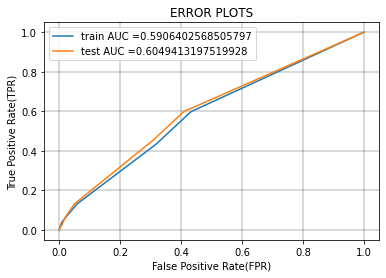

In [75]:
knn_best = KNeighborsClassifier(n_neighbors=35)
knn_best.fit(X_tr_enc, y_train)

y_score_train = knn_best.predict_proba(X_tr_enc)[:,1]
y_score_test = knn_best.predict_proba(X_te_enc)[:,1]
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_score_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_score_test)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ERROR PLOTS")
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.show()

In [76]:
knn_best.score(X_te_enc,y_test)

0.5766423357664233

### Performance Metrics for K-NN

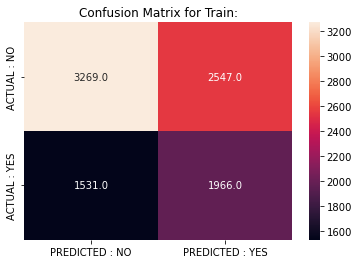

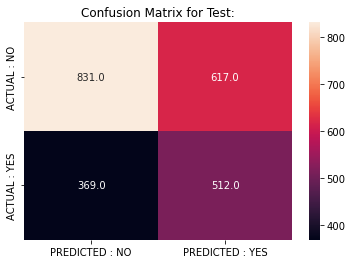

In [77]:
y_train_pred = knn_best.predict(X_tr_enc)
y_test_pred = knn_best.predict(X_te_enc)
cmtr= confusion_matrix(y_train_pred, y_train)
sns.heatmap(cmtr,annot= True,fmt='0.1f',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])
plt.title('Confusion Matrix for Train:')
plt.show()
cmte= confusion_matrix(y_test_pred, y_test)
sns.heatmap(cmte,annot= True,fmt='0.1f',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])
plt.title('Confusion Matrix for Test:')
plt.show()

In [78]:
acc_train_knn= accuracy_score(y_train,y_train_pred)
acc_test_knn= accuracy_score(y_test,y_test_pred)
auc_train_knn= roc_auc_score(y_train,y_train_pred)
auc_test_knn= roc_auc_score(y_test,y_test_pred)
f1_train_knn= f1_score(y_train,y_train_pred)
f1_test_knn= f1_score(y_test,y_test_pred)
pr_train_knn= precision_score(y_train,y_train_pred) 
pr_test_knn= precision_score(y_test,y_test_pred)
re_train_knn= recall_score(y_train,y_train_pred)
re_test_knn= recall_score(y_test,y_test_pred)

print('Accuracy score(Train):',acc_train_knn)
print('Accuracy score(Test):',acc_test_knn)
print('ROC-AUC score(Train):',auc_train_knn)
print('ROC-AUC score(Test):',auc_test_knn)
print('F1 score(Train):',f1_train_knn)
print('F1 score(Test):',f1_test_knn)
print('Precision score(Train):',pr_train_knn)
print('Precision score(Test):',pr_test_knn)
print('Recall score(Train):',re_train_knn)
print('Recall score(Test):',re_test_knn)

Accuracy score(Train): 0.5621174702029421
Accuracy score(Test): 0.5766423357664233
ROC-AUC score(Train): 0.5583360338651304
ROC-AUC score(Test): 0.5729993356953057
F1 score(Train): 0.4908863920099875
F1 score(Test): 0.5094527363184079
Precision score(Train): 0.5621961681441235
Precision score(Test): 0.5811577752553916
Recall score(Train): 0.4356304010635941
Recall score(Test): 0.4534986713906112


## Logisitic Regression

In [81]:
from sklearn.linear_model import LogisticRegression

tuned_parameters = [{'C': [0.01,0.1,1,10,20]}]
lr = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'roc_auc', cv=3)
lr.fit(X_tr_enc, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 20]}], scoring='roc_auc')

In [82]:
print(lr.best_estimator_)
best_p=lr.best_params_
print('Best Hyper-parameter:',lr.best_params_)

LogisticRegression(C=1)
Best Hyper-parameter: {'C': 1}


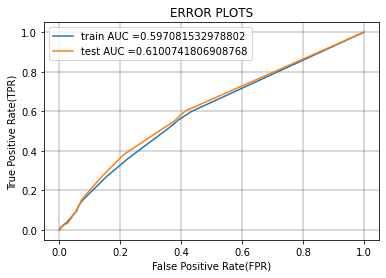

In [83]:
tuned_parameters = [{'C': [1]}]
lr_best = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'roc_auc', cv=3)
lr_best.fit(X_tr_enc, y_train)

y_score_train = lr_best.predict_proba(X_tr_enc)[:,1]
y_score_test = lr_best.predict_proba(X_te_enc)[:,1]

train_fprlr, train_tprlr, tr_thresholdslr = roc_curve(y_train, y_score_train)
test_fprlr, test_tprlr, te_thresholdslr = roc_curve(y_test, y_score_test)

plt.plot(train_fprlr, train_tprlr, label="train AUC ="+str(auc(train_fprlr, train_tprlr)))
plt.plot(test_fprlr, test_tprlr, label="test AUC ="+str(auc(test_fprlr, test_tprlr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ERROR PLOTS")
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.show()

### Performance Metrics of Logistic Regression

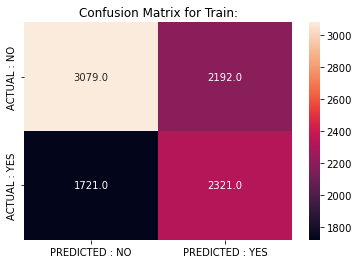

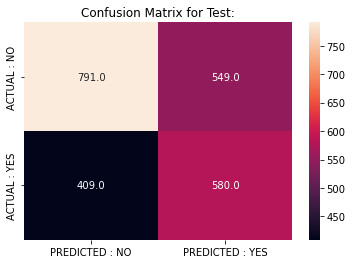

In [85]:
y_train_pred = lr_best.predict(X_tr_enc)
y_test_pred = lr_best.predict(X_te_enc)
cmtr= confusion_matrix(y_train_pred, y_train)
sns.heatmap(cmtr,annot= True,fmt='0.1f',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])
plt.title('Confusion Matrix for Train:')
plt.show()
cmte= confusion_matrix(y_test_pred, y_test)
sns.heatmap(cmte,annot= True,fmt='0.1f',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])
plt.title('Confusion Matrix for Test:')
plt.show()

In [86]:
acc_train_lr= accuracy_score(y_train,y_train_pred)
acc_test_lr= accuracy_score(y_test,y_test_pred)
auc_train_lr= roc_auc_score(y_train,y_train_pred)
auc_test_lr= roc_auc_score(y_test,y_test_pred)
f1_train_lr= f1_score(y_train,y_train_pred)
f1_test_lr= f1_score(y_test,y_test_pred)
pr_train_lr= precision_score(y_train,y_train_pred) 
pr_test_lr= precision_score(y_test,y_test_pred)
re_train_lr= recall_score(y_train,y_train_pred)
re_test_lr= recall_score(y_test,y_test_pred)

print('Accuracy score(Train):',acc_train_lr)
print('Accuracy score(Test):',acc_test_lr)
print('ROC-AUC score(Train):',auc_train_lr)
print('ROC-AUC score(Test):',auc_test_lr)
print('F1 score(Train):',f1_train_lr)
print('F1 score(Test):',f1_test)
print('Precision score(Train):',pr_train_lr)
print('Precision score(Test):',pr_test_lr)
print('Recall score(Train):',re_train_lr)
print('Recall score(Test):',re_test_lr)

Accuracy score(Train): 0.5798346397508859
Accuracy score(Test): 0.5886646629454702
ROC-AUC score(Train): 0.5778751892680405
ROC-AUC score(Test): 0.5864478151756717
F1 score(Train): 0.5426066627703099
F1 score(Test): 0.955041466608468
Precision score(Train): 0.574220682830282
Precision score(Test): 0.5864509605662285
Recall score(Train): 0.5142920452027476
Recall score(Test): 0.5137289636846767


## Naive- Bayes Classifier

In [87]:
parameter = {'alpha':[1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2]}
nb = MultinomialNB()
nb_clf = GridSearchCV(nb, parameter, cv=5,scoring='roc_auc')
nb_clf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                   0.0001, 0.001, 0.01]},
             scoring='roc_auc')

In [88]:
print(nb_clf.best_estimator_)
best_par=nb_clf.best_params_
print('Best Hyper-parameter:',nb_clf.best_params_)
nb_clf.best_score_

MultinomialNB(alpha=1e-10)
Best Hyper-parameter: {'alpha': 1e-10}


0.5197978529317157

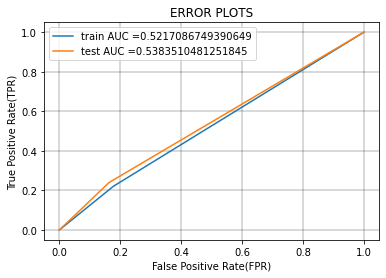

In [89]:
tuned_parameters = [{'alpha': [1e-10]}]
nb_best = GridSearchCV(nb, tuned_parameters, scoring = 'roc_auc', cv=3)
nb_best.fit(X_train, y_train)


y_score1 = nb_best.predict_proba(X_train)[:,1]
y_score2 = nb_best.predict_proba(X_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_score1)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_score2)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ERROR PLOTS")
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.show()

### Performance metrics of Naive Bayes

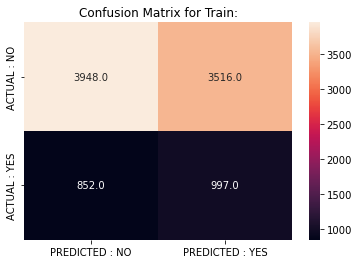

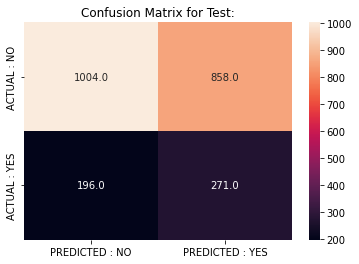

In [90]:
y_train_pred = nb_best.predict(X_train)
y_test_pred = nb_best.predict(X_test)
cmtr= confusion_matrix(y_train_pred, y_train)
sns.heatmap(cmtr,annot= True,fmt='0.1f',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])
plt.title('Confusion Matrix for Train:')
plt.show()
cmte= confusion_matrix(y_test_pred, y_test)
sns.heatmap(cmte,annot= True,fmt='0.1f',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])
plt.title('Confusion Matrix for Test:')
plt.show()

In [91]:
acc_train_nb= accuracy_score(y_train,y_train_pred)
acc_test_nb= accuracy_score(y_test,y_test_pred)
auc_train_nb= roc_auc_score(y_train,y_train_pred)
auc_test_nb= roc_auc_score(y_test,y_test_pred)
f1_train_nb= f1_score(y_train,y_train_pred)
f1_test_nb= f1_score(y_test,y_test_pred)
pr_train_nb= precision_score(y_train,y_train_pred) 
pr_test_nb= precision_score(y_test,y_test_pred)
re_train_nb= recall_score(y_train,y_train_pred)
re_test_nb= recall_score(y_test,y_test_pred)

print('Accuracy score(Train):',acc_train_nb)
print('Accuracy score(Test):',acc_test_nb)
print('ROC-AUC score(Train):',auc_train_nb)
print('ROC-AUC score(Test):',auc_test_nb)
print('F1 score(Train):',f1_train_nb)
print('F1 score(Test):',f1_test_nb)
print('Precision score(Train):',pr_train_nb)
print('Precision score(Test):',pr_test_nb)
print('Recall score(Train):',re_train_nb)
print('Recall score(Test):',re_test_nb)

Accuracy score(Train): 0.5309782025126167
Accuracy score(Test): 0.5474452554744526
ROC-AUC score(Train): 0.5217086749390649
ROC-AUC score(Test): 0.5383510481251845
F1 score(Train): 0.3134234517447344
F1 score(Test): 0.33959899749373434
Precision score(Train): 0.5392103839913467
Precision score(Test): 0.5802997858672377
Recall score(Train): 0.22091734987812986
Recall score(Test): 0.2400354295837024


## Decision Tree

In [92]:
tree = DecisionTreeClassifier(class_weight="balanced")
parameters = {'max_depth':[ 5, 10, 20, 30, 40, 50, 100, 120, 150], 'min_samples_split': [1, 2, 5, 10, 50]}
clf_dt = GridSearchCV(tree, parameters, cv=7, scoring='roc_auc',return_train_score=True)
bt=clf_dt.fit(X_train, y_train)

In [93]:
print(bt.best_estimator_)
print(bt.score(X_train,y_train))
print(bt.score(X_test,y_test))
print(bt.best_params_)

DecisionTreeClassifier(class_weight='balanced', max_depth=50,
                       min_samples_split=10)
0.9993495180589408
0.9535662090345438
{'max_depth': 50, 'min_samples_split': 10}


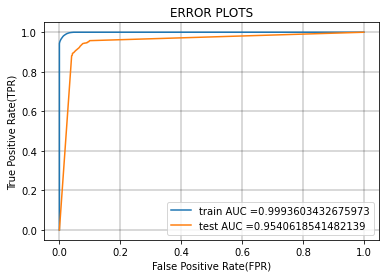

In [94]:
from sklearn.metrics import roc_curve, auc

parameters = {'max_depth':[50], 'min_samples_split': [10]}
tree = DecisionTreeClassifier(class_weight="balanced")
clf_dtb = GridSearchCV(tree, parameters, cv=5, scoring='roc_auc')
clf_dtb.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = clf_dtb.predict_proba(X_train)[:,1]    
y_test_pred = clf_dtb.predict_proba(X_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ERROR PLOTS")
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.show()

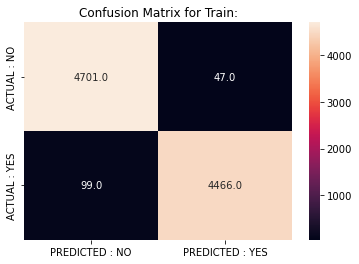

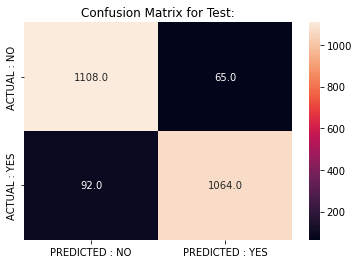

In [95]:
y_train_pred = clf_dtb.predict(X_train)
y_test_pred = clf_dtb.predict(X_test)
cmtr= confusion_matrix(y_train_pred, y_train)
sns.heatmap(cmtr,annot= True,fmt='0.1f',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])
plt.title('Confusion Matrix for Train:')
plt.show()
cmte= confusion_matrix(y_test_pred, y_test)
sns.heatmap(cmte,annot= True,fmt='0.1f',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])
plt.title('Confusion Matrix for Test:')
plt.show()

In [96]:
acc_train_dt= accuracy_score(y_train,y_train_pred)
acc_test_dt= accuracy_score(y_test,y_test_pred)
auc_train_dt= roc_auc_score(y_train,y_train_pred)
auc_test_dt= roc_auc_score(y_test,y_test_pred)
f1_train_dt= f1_score(y_train,y_train_pred)
f1_test_dt= f1_score(y_test,y_test_pred)
pr_train_dt= precision_score(y_train,y_train_pred) 
pr_test_dt= precision_score(y_test,y_test_pred)
re_train_dt= recall_score(y_train,y_train_pred)
re_test_dt= recall_score(y_test,y_test_pred)

print('Accuracy score(Train):',acc_train_dt)
print('Accuracy score(Test):',acc_test_dt)
print('ROC-AUC score(Train):',auc_train_dt)
print('ROC-AUC score(Test):',auc_test_dt)
print('F1 score(Train):',f1_train_dt)
print('F1 score(Test):',f1_test_dt)
print('Precision score(Train):',pr_train_dt)
print('Precision score(Test):',pr_test_dt)
print('Recall score(Train):',re_train_dt)
print('Recall score(Test):',re_test_dt)

Accuracy score(Train): 0.9843229893696983
Accuracy score(Test): 0.9325890940317733
ROC-AUC score(Train): 0.9844803207400843
ROC-AUC score(Test): 0.9328801299084736
F1 score(Train): 0.9839171623705661
F1 score(Test): 0.9312910284463894
Precision score(Train): 0.9783132530120482
Precision score(Test): 0.9204152249134948
Recall score(Train): 0.9895856414801684
Recall score(Test): 0.9424269264836138


## Random Forest

In [111]:

param_dist = {"n_estimators":list(range(100,120)),
              "min_samples_split": list(range(1,20)),
              "min_samples_leaf": list(range(1,10))}

clf = RandomForestClassifier()

rf_clf = RandomizedSearchCV(clf, param_distributions=param_dist,n_iter=3,cv=7,scoring='roc_auc')

rf_clf.fit(X_train,y_train)
rf_clf.best_score_

0.9835516995564071

In [112]:
print(rf_clf.best_estimator_)
best_p= rf_clf.best_params_
print('Best Hyper-parameter:',rf_clf.best_params_)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=13,
                       n_estimators=106)
Best Hyper-parameter: {'n_estimators': 106, 'min_samples_split': 13, 'min_samples_leaf': 4}


In [107]:
rf_best=RandomForestClassifier(min_samples_leaf=2, min_samples_split=3,
                       n_estimators=102)

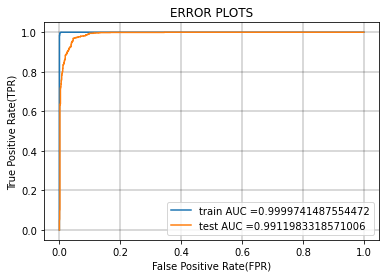

In [108]:
rf_best.fit(X_train, y_train)

y_score1 = rf_best.predict_proba(X_train)[:,1]
y_score2 = rf_best.predict_proba(X_test)[:,1]
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_score1)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_score2)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ERROR PLOTS")
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.show()

### Performance metrics of Random Forest

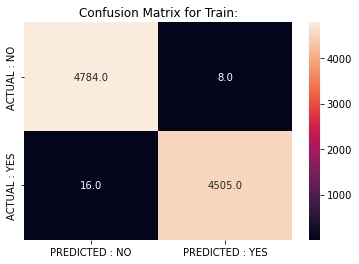

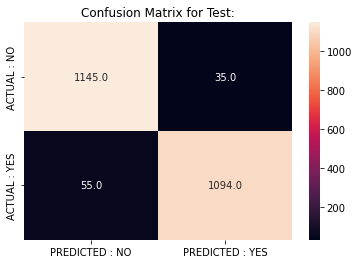

In [109]:
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)
cmtr= confusion_matrix(y_train_pred, y_train)
sns.heatmap(cmtr,annot= True,fmt='0.1f',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])
plt.title('Confusion Matrix for Train:')
plt.show()
cmte= confusion_matrix(y_test_pred, y_test)
sns.heatmap(cmte,annot= True,fmt='0.1f',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])
plt.title('Confusion Matrix for Test:')
plt.show()

In [113]:
acc_train_rf= accuracy_score(y_train,y_train_pred)
acc_test_rf= accuracy_score(y_test,y_test_pred)
auc_train_rf= roc_auc_score(y_train,y_train_pred)
auc_test_rf= roc_auc_score(y_test,y_test_pred)
f1_train_rf= f1_score(y_train,y_train_pred)
f1_test_rf= f1_score(y_test,y_test_pred)
pr_train_rf= precision_score(y_train,y_train_pred) 
pr_test_rf= precision_score(y_test,y_test_pred)
re_train_rf= recall_score(y_train,y_train_pred)
re_test_rf= recall_score(y_test,y_test_pred)

print('Accuracy score(Train):',acc_train_rf)
print('Accuracy score(Test):',acc_test_rf)
print('ROC-AUC score(Train):',auc_train_rf)
print('ROC-AUC score(Test):',auc_test_rf)
print('F1 score(Train):',f1_train_rf)
print('F1 score(Test):',f1_test_rf)
print('Precision score(Train):',pr_train_rf)
print('Precision score(Test):',pr_test_rf)
print('Recall score(Train):',re_train_rf)
print('Recall score(Test):',re_test_rf)

Accuracy score(Train): 0.9974229571566627
Accuracy score(Test): 0.961356805495921
ROC-AUC score(Train): 0.9974470049486668
ROC-AUC score(Test): 0.9615828904635371
F1 score(Train): 0.9973433694930264
F1 score(Test): 0.9604916593503073
Precision score(Train): 0.9964609599646096
Precision score(Test): 0.9521322889469104
Recall score(Train): 0.998227343230667
Recall score(Test): 0.9689991142604074


## Boosting(Light gbm) 

In [114]:
parameters = {'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3] , 'n_estimators': [10, 50, 75, 100, 200]}
lgb_train=lgb.Dataset(X_train,label=y_train)
lgbm_test=lgb.Dataset(X_test,label=y_test,reference=lgb_train)
model1=lgb.LGBMClassifier()

lgbm = GridSearchCV(model1,param_grid=parameters, cv=3, scoring='roc_auc',n_jobs=10,return_train_score=True)
lgb_clf= lgbm.fit(X_train,y_train)

In [36]:
print(lgb_clf.best_estimator_)
print(lgb_clf.score(X_train,y_train))
print(lgb_clf.score(X_test,y_test))
print(lgb_clf.best_params_)

LGBMClassifier(learning_rate=0.3, n_estimators=200)
0.9999269240712018
0.9861592116917627
{'learning_rate': 0.3, 'n_estimators': 200}


In [37]:
best_lr= lgb_clf.best_params_['learning_rate']
best_est= lgb_clf.best_params_['n_estimators']
best_score= lgb_clf.best_score_
best_lp= lgb_clf.best_params_

print("Best Learning Rate:", best_lr)
print("Best n_estimators:",best_est)
print("Best Score:",best_score)

Best Learning Rate: 0.3
Best n_estimators: 200
Best Score: 0.9846469306286963


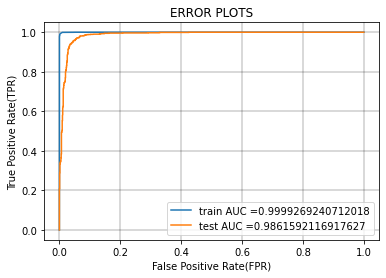

In [38]:
parameters = {'learning_rate':[0.3], 'n_estimators': [200]}

best_model = lgb.LGBMClassifier(n_estimators =best_est,learning_rate =best_lr)
lgb_best = GridSearchCV(best_model, parameters, cv=5, scoring='roc_auc')
lgb_best.fit(X_train, y_train)

y_train_pred = lgb_best.predict_proba(X_train)[:,1]    
y_test_pred = lgb_best.predict_proba(X_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ERROR PLOTS")
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.show()

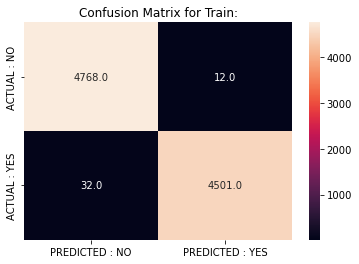

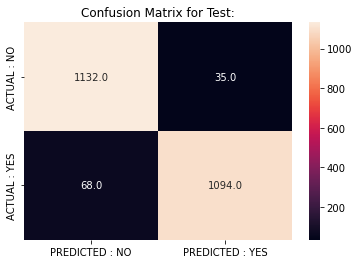

In [39]:
y_train_pred = lgb_best.predict(X_train)
y_test_pred = lgb_best.predict(X_test)
cmtr= confusion_matrix(y_train_pred, y_train)
sns.heatmap(cmtr,annot= True,fmt='0.1f',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])
plt.title('Confusion Matrix for Train:')
plt.show()
cmte= confusion_matrix(y_test_pred, y_test)
sns.heatmap(cmte,annot= True,fmt='0.1f',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])
plt.title('Confusion Matrix for Test:')
plt.show()

In [115]:
acc_train_lgb= accuracy_score(y_train,y_train_pred)
acc_test_lgb= accuracy_score(y_test,y_test_pred)
auc_train_lgb= roc_auc_score(y_train,y_train_pred)
auc_test_lgb= roc_auc_score(y_test,y_test_pred)
f1_train_lgb= f1_score(y_train,y_train_pred)
f1_test_lgb= f1_score(y_test,y_test_pred)
pr_train_lgb= precision_score(y_train,y_train_pred) 
pr_test_lgb= precision_score(y_test,y_test_pred)
re_train_lgb= recall_score(y_train,y_train_pred)
re_test_lgb= recall_score(y_test,y_test_pred)

print('Accuracy score(Train):',acc_train_lgb)
print('Accuracy score(Test):',acc_test_lgb)
print('ROC-AUC score(Train):',auc_train_lgb)
print('ROC-AUC score(Test):',auc_test_lgb)
print('F1 score(Train):',f1_train_lgb)
print('F1 score(Test):',f1_test_lgb)
print('Precision score(Train):',pr_train_lgb)
print('Precision score(Test):',pr_test_lgb)
print('Recall score(Train):',re_train_lgb)
print('Recall score(Test):',re_test_lgb)

Accuracy score(Train): 0.9974229571566627
Accuracy score(Test): 0.961356805495921
ROC-AUC score(Train): 0.9974470049486668
ROC-AUC score(Test): 0.9615828904635371
F1 score(Train): 0.9973433694930264
F1 score(Test): 0.9604916593503073
Precision score(Train): 0.9964609599646096
Precision score(Test): 0.9521322889469104
Recall score(Train): 0.998227343230667
Recall score(Test): 0.9689991142604074


### Feature Importance 

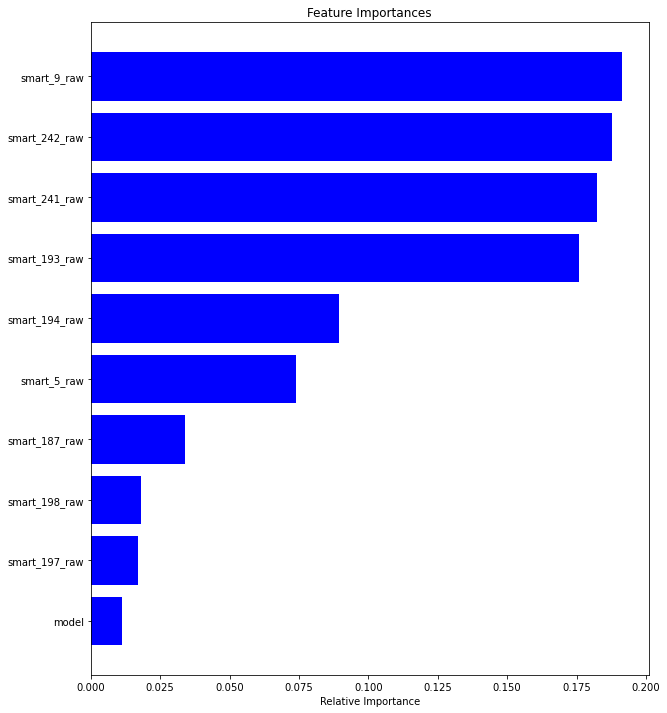

In [41]:
features = X.columns
importances = rf_best.feature_importances_
indices = (np.argsort(importances))[-10:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### SMART- 9, 242, 241 and 193 have high and almost same feature importance

## Custom Model

In [55]:
class Custom:
    #initializing all the variables 
    def __init__(self,k,sample,X_train,y_train,x_test,y_test):
        self.k= k
        self.X= X_train.copy()
        self.y= y_train.copy()
        self.sample= sample
        self.x_val= x_test
        self.y_val= y_test
#-------------------------------------------------------------------------------------------------------------------        
    #Sampling Dataset d1 randomly
    def data_sampling(self):
        self.X['failure']= self.y
        d1= self.X.sample(frac=0.5)
        d2= self.X.drop(d1.index)
        samp_ls=[]
        for i in range(self.k):
            s= d1.sample(self.sample)
            samp_ls.append(s)
         
        #print(samp_ls)
        data=[samp_ls,d2]
        return data
#--------------------------------------------------------------------------------------------------------------------    
    #Choosing Base model RF and DT randomly
    @staticmethod
    def model_choice(k):
        rf= rf= RandomForestClassifier(min_samples_leaf=2, min_samples_split=3,n_estimators=102)
        dt= DecisionTreeClassifier(class_weight='balanced', max_depth=30,min_samples_split=10)
        lg= lgb.LGBMClassifier(learning_rate=0.3, n_estimators=200)
        model=[rf,lg]
        ch= model*(k//len(model))
        #print(len(ls))
        return ch
#--------------------------------------------------------------------------------------------------------------------    
    #Training Model with Dataset d1 and testing on Dataset d2
    def create_meta_data(self):
        meta=[]
        data=[]
        d1_pred=[]
        d2_pred=[]
        val_pred=[]
        c= self.model_choice(k) #Selecting model randomly k-times
        ls= self.data_sampling() #Sampling d1 dataset multiple times
        d1= ls[0]
        d2= ls[1]
        #xtr_d2=self.x_d2.copy()
        x_eval= self.x_val.copy()
        y_d2= d2['failure']
        x_d2= d2.drop('failure',axis=1)
        #Training the model on d1 sample and then testing on d2 dataset 
        for i in range(self.k):
            y_train= d1[i]['failure']
            x_train= d1[i].drop('failure',axis=1)
            model=c[i].fit(x_train,y_train)
            y_train_pred = model.predict(x_train) #Predicting d1 sample dataset
            yd_train_pred = model.predict(x_d2) #Predicting d2 sample dataset
            yx_test_pred = model.predict(self.x_val) #Predicting X_test dataset
            #score= f1_score(yd_train_pred,self.y_d2)
            meta.append(c[i]) #Storing base-model in list 
            #pm.append({c[i]:score})
            d1_pred.append(y_train_pred) #appending d1 prediction value
            d2_pred.append(yd_train_pred) #Appending d2 prediction value
            val_pred.append(yx_test_pred) #Appending X_test prediction value
            
        #Creating new columns name for meta-data 
        pred=[]
        for i in range(self.k):
            p='pred_'+str(i)
            pred.append(p)
            
        
        #Creating a dataframe from new predicted data and then joining it with actual dataframe d2 
        d2_dict={}
        for i,v in enumerate(pred):
            d2_dict[v]=d2_pred[i]
        
        yd_dict=dict()
        yd2= np.array(y_d2)
        yd_dict['failure']= yd2
        
        d2_dict.update(yd_dict)
        x_d2.reset_index(drop=True, inplace=True)
        d2_df= pd.DataFrame.from_dict(d2_dict)
        
        
        frame_d2= [x_d2,d2_df]
        meta_d2= pd.concat(frame_d2, axis=1)
        
        #Creating a dataframe from new predicted data and then joining it with actual dataframe x_val
        val_dict={}
        for i,v in enumerate(pred):
            val_dict[v]= val_pred[i]
        
        yv_dict=dict()
        yv= np.array(self.y_val)
        yv_dict['failure']= yv
        
        val_dict.update(yv_dict)
        x_eval.reset_index(drop=True, inplace=True)
        test_df= pd.DataFrame.from_dict(val_dict)
        
        
        frame_val= [x_eval,test_df]
        meta_val= pd.concat(frame_val, axis=1)
            
        values= dict()
        values['meta']=meta
        values['d2_meta']=meta_d2
        values['val_meta']=meta_val
        #print(values['data'])
            
        return values
#-----------------------------------------------------------------------------------------------------------------------    
    #Model Evaluation 
    def meta_model(self):
        
        m= self.create_meta_data()
        train= m['d2_meta']
        test= m['val_meta']
        #print(train)
        y_train= train['failure']
        x_train= train.drop('failure',axis=1)
        y_test= test['failure']
        x_test= test.drop('failure',axis=1)
        #Final Evaluation Training on D2(meta-data) dataset and Test dataset(meta-data)
        meta_model= lgb.LGBMClassifier(learning_rate=0.3, n_estimators=200).fit(x_train,y_train)
        y_test_pred= meta_model.predict(x_test)
        f1= f1_score(y_test_pred,y_test)
        auc= roc_auc_score(y_test_pred,y_test)
        acc= accuracy_score(y_test_pred,y_test)
        pr= precision_score(y_test_pred,y_test)
        re= recall_score(y_test_pred,y_test)
        score= dict()
        score['accuracy']= acc
        score['f1']= f1
        score['roc_auc']= auc
        score['precision']= pr
        score['recall']= re
        
        return score
        

In [121]:
k=10 #K is the number of times data sample wil be created randomly, k must be even number
sample= 4000 #number of datapoints for each k- dataset
c= Custom(k,sample,X_train,y_train,X_test,y_test)
score= c.meta_model()
f1_test_custom= score['f1']
acc_test_custom= score['accuracy']
auc_test_custom= score['roc_auc']
pr_test_custom= score['precision']
re_test_custom= score['recall']

print('Accuracy score(Test):',acc_test_custom)
print('ROC-AUC score(Test):',auc_test_custom)
print('F1 score(Test):',f1_test_custom)
print('Precision score(Test):',pr_test_custom)
print('Recall score(Test):',re_test_custom)

In [122]:
from prettytable import PrettyTable
p= PrettyTable()
p.field_names=['Model','Accuracy','F1-Score','AUC Score','Precision','Recall']
p.add_row(['K-NN', acc_test_knn, f1_test_knn, auc_test_knn, pr_test_knn, re_test_knn])
p.add_row(['Logistic-Regression', acc_test_lr, f1_test_lr, auc_test_lr, pr_test_lr, re_test_lr])
p.add_row(['Naive-Bayes', acc_test_nb, f1_test_nb, auc_test_nb, pr_test_nb, re_test_nb])
p.add_row(['Decision Tree', acc_test_dt, f1_test_dt, auc_test_dt, pr_test_dt, re_test_dt])
p.add_row(['Random Forest', acc_test_rf, f1_test_rf, auc_test_rf, pr_test_rf, re_test_rf])
p.add_row(['Light-GBM', acc_test_rf, f1_test_rf, auc_test_rf, pr_test_rf, re_test_rf])
p.add_row(['Custom-Model', acc_test_custom, f1_test_custom, auc_test_custom, pr_test_custom, re_test_custom])
print(p)

+---------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|        Model        |      Accuracy      |       F1-Score      |     AUC Score      |     Precision      |       Recall       |
+---------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|         K-NN        | 0.5766423357664233 |  0.5094527363184079 | 0.5729993356953057 | 0.5811577752553916 | 0.4534986713906112 |
| Logistic-Regression | 0.5886646629454702 |  0.5476864966949953 | 0.5864478151756717 | 0.5864509605662285 | 0.5137289636846767 |
|     Naive-Bayes     | 0.5474452554744526 | 0.33959899749373434 | 0.5383510481251845 | 0.5802997858672377 | 0.2400354295837024 |
|    Decision Tree    | 0.9325890940317733 |  0.9312910284463894 | 0.9328801299084736 | 0.9204152249134948 | 0.9424269264836138 |
|    Random Forest    | 0.961356805495921  |  0.9604916593503073 | 0.9615828904635371 | 0.